# Libraries

In [1]:
from datetime import date, datetime
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
# pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import random
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

In [2]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import gspread
from google.auth import default
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
import requests
from gspread_dataframe import set_with_dataframe
from google.colab import files
from datetime import datetime, timedelta
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Load data

In [3]:
#schema = pd.read_csv('./survey_results_schema.csv')
#survey = pd.read_csv('./survey_results_public.csv')

In [4]:
enlace = 'https://drive.google.com/file/d/1-6xLuyL2QQsFOke6vEL7zHtEp2S5ZSdv/view?usp=drive_link' # survey 2023
enlace = 'https://drive.google.com/file/d/1Qq5XIeyN3PrNUjuQAVqzVHlH4z0UWpjm/view?usp=drive_link' # survey 2023
id = enlace.split('/')[-2]
file = drive.CreateFile({'id': id})
file.GetContentFile('survey.csv')
survey = pd.read_csv('survey.csv')

enlace = 'https://drive.google.com/file/d/1KfIllJ5m8tO7fZKbmJ4sFz6s3zgSqCLQ/view?usp=drive_link' # schema 2023
enlace = 'https://drive.google.com/file/d/15It32kFBAtcN2Qs3XW9if4Xf8KUMUIHC/view?usp=drive_link' # schema 2023
id = enlace.split('/')[-2]
file = drive.CreateFile({'id': id})
file.GetContentFile('schema.csv')
schema = pd.read_csv('schema.csv')

# EDA and Data transformation

## Preliminary

In [5]:
schema['type'].value_counts()

type
MC        48
Matrix    16
DB         9
TE         3
Meta       1
Slider     1
Name: count, dtype: int64

In [6]:
schema[schema['type'] == 'TE']

,qid,qname,question,force_resp,type,selector
24,QID51,CompTotal,What is your current total <b>annual</b> compe...,False,TE,SL
45,QID325,SOAI,Artificial Intelligence (AI) tools have gained...,False,TE,SL
52,QID321,AIOpen,Please describe how you would expect your work...,False,TE,SL


In [7]:
survey['Q120'].value_counts()

Q120
I agree    89184
Name: count, dtype: int64

Two first columns have not importance: ResponseId, Q120

In [8]:
columns_to_drop = ['ResponseId', 'Q120', 'SOAI']

survey.drop(columns=columns_to_drop, inplace=True)
print(survey.shape)

(89184, 81)


In [9]:
survey.dropna(subset=['ConvertedCompYearly'], axis=0, inplace=True)
print(survey.shape)

(48019, 81)


In [10]:
survey = survey[survey['ConvertedCompYearly'] < np.quantile(survey['ConvertedCompYearly'], 0.95)]

In [11]:
def java_python(string):
    if string in ['Java', 'Python']: return string
    elif re.search('Python', string):
        if re.search('Java[;].*', string):
            return False
        else: return 'Python'
    elif re.search('Java[;].*', string):
        if re.search('Python', string):
            return False
        else: return 'Java'
    else: return False
java_python('Java')

'Java'

In [12]:
survey['Python or Java'] = survey['LanguageHaveWorkedWith'].apply(lambda x: java_python(str(x)))
survey = survey[survey['Python or Java'].isin(['Java', 'Python'])]
print(survey.shape)
print(survey['Python or Java'].value_counts())

(20353, 82)
Python or Java
Python    14256
Java       6097
Name: count, dtype: int64


In [13]:
java = survey[survey['Python or Java'] == 'Java'].copy()
python = survey[survey['Python or Java'] == 'Python'].copy()

In [14]:
def variable_barplot(column, language):
  categories = set()
  column = column.astype(str)
  unique_values = np.unique(column.str.split(';'))
  for categories_list in unique_values:
    categories = categories | set(categories_list)
  categories = list(categories - {language})

  frequency = []
  for language in categories:
    c = 0
    for lista in column.str.split(';'):
      if language in lista: c += 1
    frequency.append(c)

  def addlabels(x, y):
    for i in range(len(x)):
      plt.text(i, y[i], f'{round(y[i]*100, 1)}%', ha='center', fontsize='x-small')

  df = pd.DataFrame({'language': categories, 'frequency': frequency}).sort_values(by='frequency', ascending=False).reset_index(drop=True)
  df['%'] = df['frequency']/df['frequency'].sum()
  df[:20].plot(kind='bar', x='language', y='%', width=1, legend=None, ylabel='frequency', rot=90)
  addlabels(x=df['language'][:20], y=df['%'][:20])

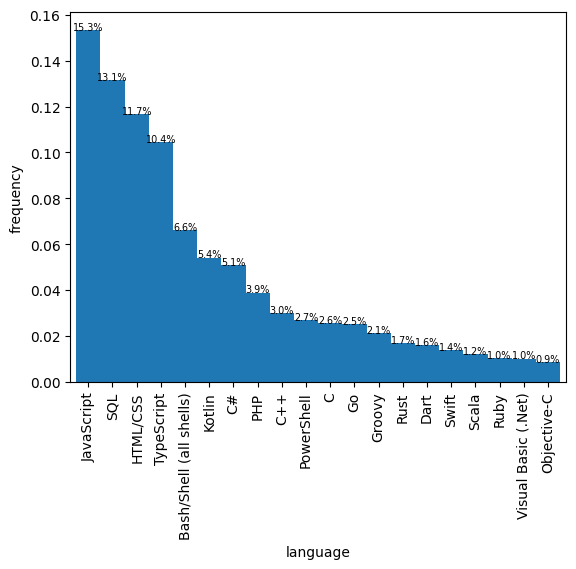

In [15]:
variable_barplot(java['LanguageHaveWorkedWith'], 'Java')

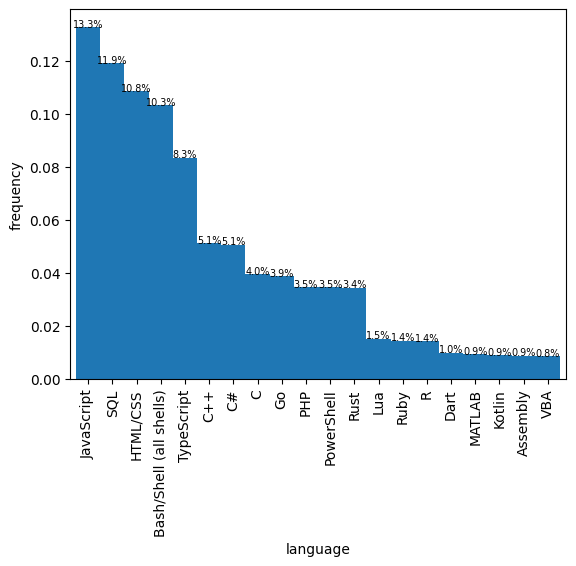

In [16]:
variable_barplot(python['LanguageHaveWorkedWith'], 'Python')

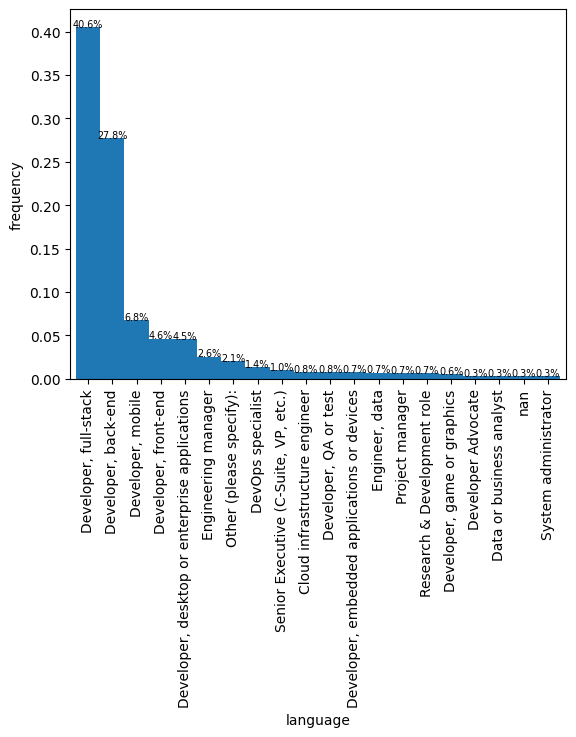

In [17]:
variable_barplot(java['DevType'], '')

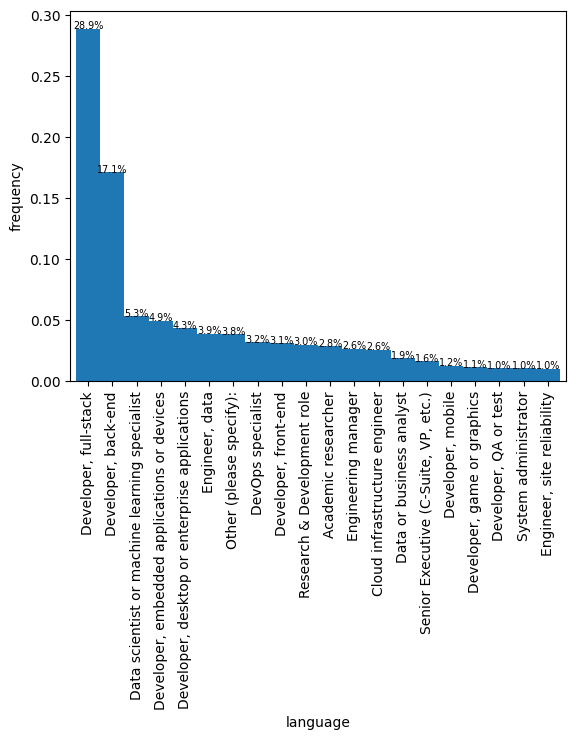

In [18]:
variable_barplot(python['DevType'], '')

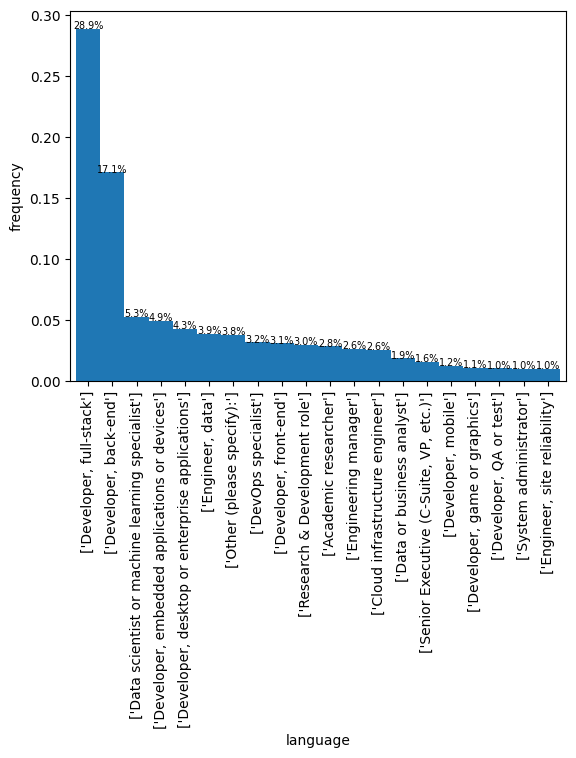

In [19]:
variable_barplot(python['DevType'].str.split(';'), 'Python')

## Java

In [20]:
java.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6097 entries, 6 to 89171
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MainBranch                           6097 non-null   object 
 1   Age                                  6097 non-null   object 
 2   Employment                           6094 non-null   object 
 3   RemoteWork                           6082 non-null   object 
 4   CodingActivities                     6080 non-null   object 
 5   EdLevel                              6097 non-null   object 
 6   LearnCode                            6089 non-null   object 
 7   LearnCodeOnline                      4765 non-null   object 
 8   LearnCodeCoursesCert                 2872 non-null   object 
 9   YearsCode                            6083 non-null   object 
 10  YearsCodePro                         6070 non-null   object 
 11  DevType                           

In [21]:
java.sample(2)

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly,Python or Java
76439,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Bootstrapping a business;Professional developm...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;Online Course...,Formal documentation provided by the owner of ...,Other;Udemy;Coursera;Udacity,11,6,"Developer, full-stack",100 to 499 employees,I have little or no influence,NaN,Start a free trial;Ask developers I know/work ...,France,EUR European Euro,47500.0,HTML/CSS;Java;JavaScript;SQL,Bash/Shell (all shells);Go;Groovy;HTML/CSS;Jav...,Elasticsearch;PostgreSQL,BigQuery;Cassandra;Cosmos DB;Elasticsearch;Fir...,NaN,NaN,React;Spring Boot,Angular;AngularJS;Django;Express;NestJS;Next.j...,Apache Kafka;Spring Framework,Apache Kafka;Apache Spark;Flutter;Hadoop;Micro...,Ansible;Maven (build tool),Ansible;Docker;Gradle;Kubernetes;Maven (build ...,IntelliJ IDEA;Notepad++,Android Studio;IntelliJ IDEA;Jupyter Notebook/...,Android;Windows,Debian;Windows;Windows Subsystem for Linux (WSL),Confluence;Jira;Markdown File;Miro;Trello,Confluence;Jira;Markdown File;Miro;Trello,Google Meet;Microsoft Teams;Slack;Whatsapp,Google Meet;Microsoft Teams;Slack;Whatsapp,NaN,NaN,NaN,NaN,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,"Yes, somewhat","No, but I plan to soon",Indifferent,NaN,Neither trust nor distrust,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Individual contributor,6.0,Strongly agree,Agree,Agree,Agree,Agree,Disagree,Agree,Agree,1-2 times a week,1-2 times a week,1-2 times a week,Less than 15 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,50868.0,Java
61659,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Blogs with tips and tricks;Books;How-to videos...,NaN,7,7,"Developer, back-end",20 to 99 employees,I have little or no influence,NaN,Start a free trial;Ask developers I know/work ...,Russian Federation,USD\tUnited States dollar,60000.0,Clojure;Dart;Groovy;Java;JavaScript;Kotlin;Lua...,Clojure;Kotlin,PostgreSQL;Redis,Datomic,Amazon Web Services (AWS);Heroku,NaN,Vue.js,NaN,Flutter;Ktor;RabbitMQ,Flutter;Ktor,Docker;Kubernetes;npm;Podman;Yarn,Docker,Android Studio;IntelliJ IDEA;Neovim,Neovim,MacOS,MacOS,Notion,Notion,Slack;Zoom,Slack;Zoom,ChatGPT,ChatGPT,Codeium,Codeium;GitHub Copilot,Stack Overflow;Stack Exchange,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [22]:
java['ConvertedCompYearly'].describe()

count      6097.000000
mean      75303.028867
std       50355.140960
min           1.000000
25%       38552.000000
50%       66036.000000
75%      103824.000000
max      228414.000000
Name: ConvertedCompYearly, dtype: float64

<Axes: >

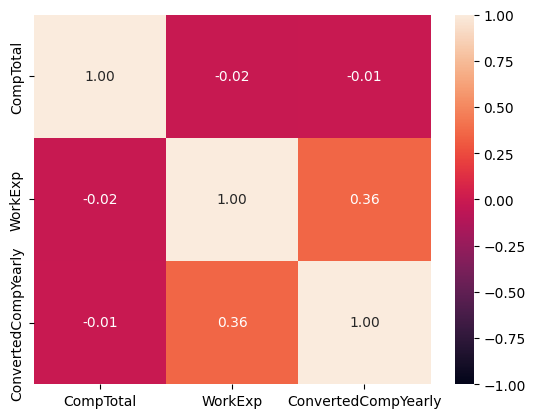

In [23]:
sns.heatmap(java.select_dtypes('float64', 'int').corr(), vmin=-1, vmax=1, annot=True, fmt='.2f') # numerical variables are not explicative of objective variable

In [24]:
survey_schema = pd.DataFrame({'question': survey.columns}).merge(schema[['qname', 'question']], left_on='question', right_on='qname', how='left')

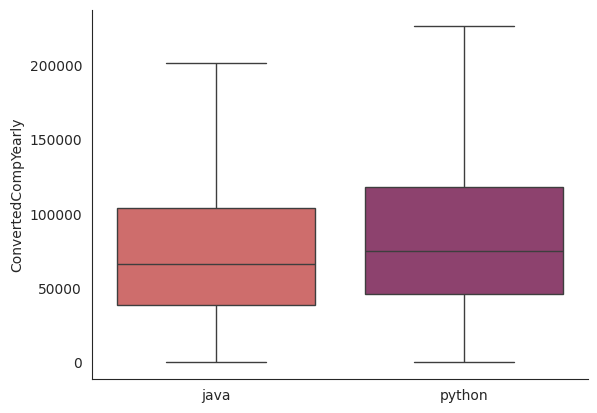

In [25]:
combined_dfs = pd.DataFrame({'java': java['ConvertedCompYearly'],
                             'python': python['ConvertedCompYearly']})
sns.set_style('white')
sns.boxplot(data=combined_dfs, palette='flare', showfliers=False)
sns.despine()
plt.ylabel('ConvertedCompYearly')
plt.show()

AISearchWantToWorkWith


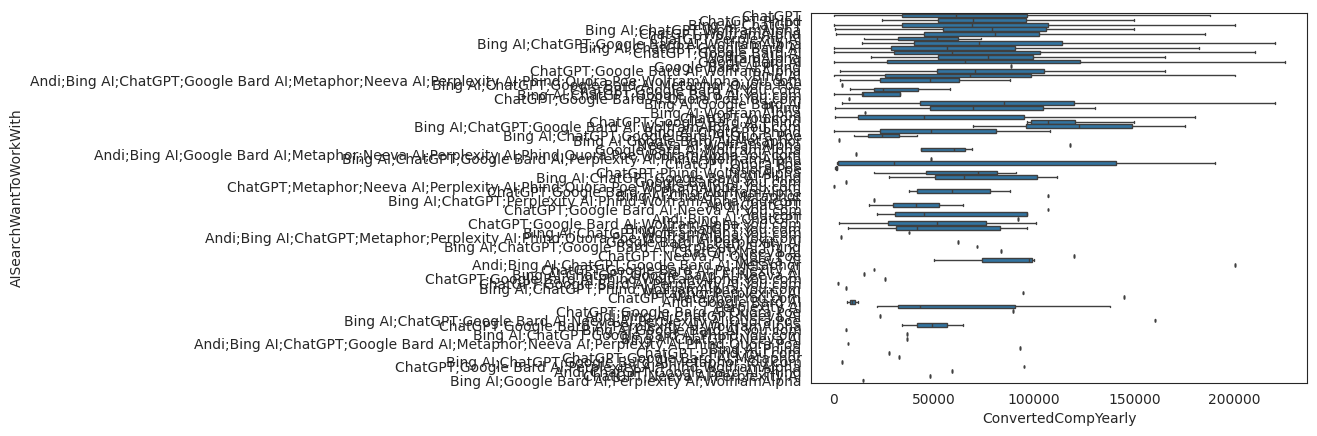

In [26]:
column = java.columns[40]
print(column)
sns.boxplot(data=java, x='ConvertedCompYearly', y=column, showfliers=False);

In [27]:
objective_variable = ['ConvertedCompYearly']
categorical_variables = java.select_dtypes(include=['object']).columns

excluir = ['Python or Java', 'Currency']
categorical_variables = categorical_variables[~categorical_variables.isin(excluir)]

In [28]:
categorical_variables

Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities',
       'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence',
       'TechList', 'BuyNewTool', 'Country', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWantToWorkWith', 'AIDevHaveWorkedWith', 'AIDevWantToWorkW

Imputing missing values

In [29]:
java_selected = pd.concat([java[categorical_variables], java[objective_variable]], axis=1).reset_index(drop=True)

In [30]:
java_selected.shape

(6097, 78)

In [31]:
java_selected.describe(include='all')

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
count,6097,6097,6094,6082,6080,6097,6089,4765,2872,6083,6070,6077,6092,6090,3484,5868,6097,6097,5670,5690,4751,4690,3766,5076,4339,4439,3691,5769,5043,6048,5424,6018,5696,5482,4280,5962,5013,3433,2798,1388,1002,6097,6077,6096,4832,6088,6097,3999,2207,3992,1910,2073,1262,657,408,371,153,1319,5891,4217,4142,4065,4085,4085,4077,4076,4070,4061,4116,4118,4050,4168,4156,4126,3604,6046,6047,6097.000000
unique,2,7,12,3,75,8,417,1794,117,52,49,33,10,3,3,150,132,2759,2990,2079,1668,937,771,1811,1606,1041,1150,3107,2592,2244,1600,574,504,1000,665,1356,840,58,80,33,43,15,5,3,6,6,3,6,47,5,371,183,204,103,54,47,37,113,2,2,5,5,5,5,5,5,5,5,5,5,5,5,5,195,12,3,3,NaN
top,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,Udemy,10,5,"Developer, full-stack",100 to 499 employees,I have little or no influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,Java,Java,PostgreSQL,PostgreSQL,Amazon Web Services (AWS),Amazon Web Services (AWS),Spring Boot,Spring Boot,Spring Framework,Spring Framework,Maven (build tool),Maven (build tool),IntelliJ IDEA;Visual Studio Code,IntelliJ IDEA;Visual Studio Code,Windows,MacOS,Confluence;Jira,Jira,Microsoft Teams,Microsoft Teams,ChatGPT,ChatGPT,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,"No, not really",Yes,Favorable,Increase productivity;Greater efficiency;Speed...,Somewhat trust,Learning about a codebase;Project planning;Wri...,Writing code,Collaborating with teammates,Writing code,Writing code,Writing code,Writing code,Writing code,Yes,Individual contributor,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,1-2 times a week,1-2 times a week,1-2 times a week,30-60 minutes a day,15-30 minutes a day,None of these,"Information Services, IT, Software Development...",Appropriate in length,Easy,NaN
freq,5899,2829,5066,2844,1439,3029,253,95,712,493,497,2474,1254,2562,3055,1042,951,287,169,370,474,985,763,543,438,902,471,211,159,463,410,1270,1164,803,583,693,577,2283,1488,967,695,3520,2003,4843,2607,1976,2230,1965,371,1506,84,378,111,81,103,147,60,354,4235,3687,2015,1372,1625,1831,2181,1532,1516,1602,2621,1939,2165,1608,1382,363,1749,4720,3879,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [32]:
java_selected.dropna(subset=categorical_variables, how='all', axis=0, inplace=True) #empty rows
java_selected.dropna(how='all', axis=1, inplace=True) #empty columns
print(java_selected.shape)

(6097, 78)


In [33]:
for columna in java_selected[categorical_variables]:
    java_selected[columna].fillna(java_selected[columna].mode(), inplace=True)

In [34]:
def create_dummy_df(df, categorical_variables):
  for columna in categorical_variables:
    try:
      df = pd.concat([df.drop(columna, axis=1), pd.get_dummies(df[columna], prefix=columna, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    except:
      continue
  return df

java_dummy = create_dummy_df(java_selected, categorical_variables)

## Python

In [35]:
python['ConvertedCompYearly'].describe()

count     14256.000000
mean      84097.075056
std       52726.141168
min           1.000000
25%       45874.250000
50%       74963.000000
75%      118000.000000
max      229789.000000
Name: ConvertedCompYearly, dtype: float64

<Axes: >

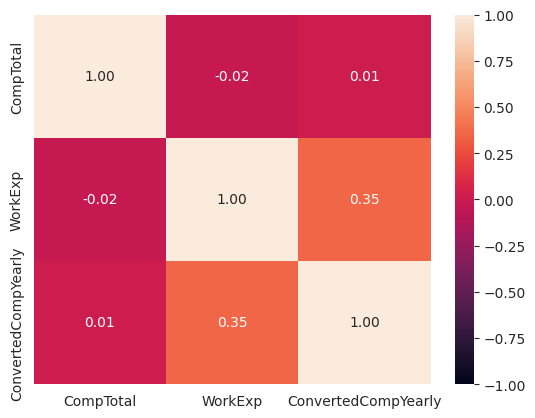

In [36]:
sns.heatmap(python.select_dtypes('float64', 'int').corr(), vmin=-1, vmax=1, annot=True, fmt='.2f') # numerical variables are not explicative of objective variable

AISearchWantToWorkWith


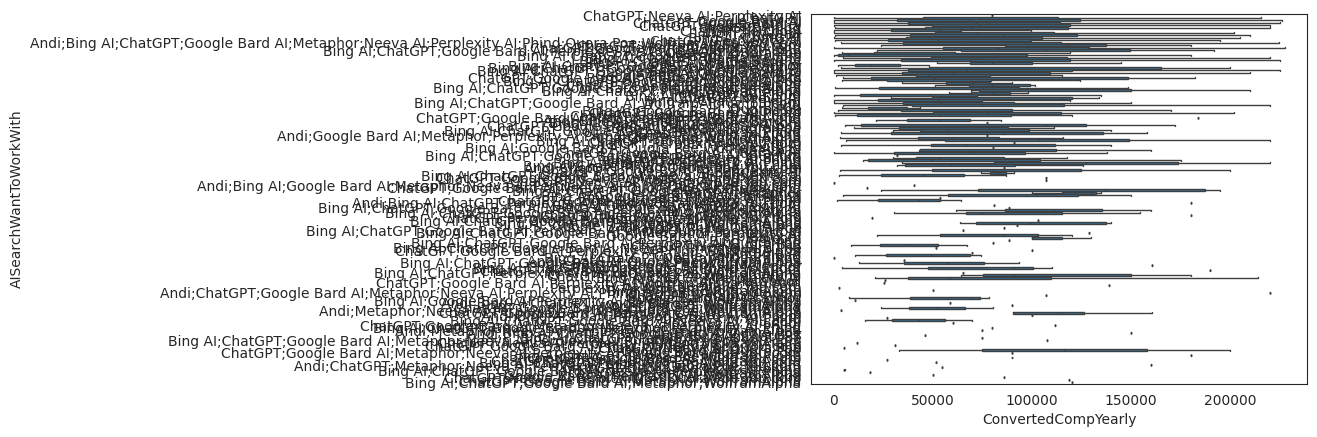

In [37]:
column = python.columns[40]
print(column)
sns.boxplot(data=python, x='ConvertedCompYearly', y=column, showfliers=False);

Imputing missing values

In [38]:
python_selected = pd.concat([python[categorical_variables], python[objective_variable]], axis=1).reset_index(drop=True)

In [39]:
python_selected.shape

(14256, 78)

In [40]:
python_selected.describe(include='all')

,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
count,14256,14256,14251,14234,14230,14256,14233,11565,6024,14241,14202,14226,14246,14245,9300,13726,14256,14256,13416,12075,10172,11086,9013,10399,8782,9969,8281,13175,11754,14158,12786,14159,13507,12431,9678,14014,11834,9315,7709,4481,3512,14256,14222,14252,11011,14238,14256,10026,6634,10017,5871,6341,3797,2269,1013,1049,464,4181,13781,9813,9681,9572,9587,9572,9546,9544,9542,9524,9557,9567,9449,9682,9667,9504,8263,14110,14129,14256.000000
unique,2,8,13,3,94,8,527,3064,144,52,52,33,10,3,3,188,147,5775,6286,3056,2902,1878,1464,3726,3332,2754,3204,7677,6610,4837,3458,1077,898,2183,1300,2417,1534,125,148,58,92,16,5,3,6,6,3,6,56,5,477,286,300,173,88,92,65,187,2,2,5,5,5,5,5,5,5,5,5,5,5,5,5,240,12,3,3,NaN
top,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Formal documentation provided by the owner of ...,Udemy,10,5,"Developer, full-stack",20 to 99 employees,I have some influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,Python,Python,PostgreSQL,PostgreSQL,Amazon Web Services (AWS),Amazon Web Services (AWS),Flask,FastAPI,NumPy;Pandas,.NET (5+),Pip,Docker,Visual Studio Code,Visual Studio Code,Windows,MacOS,Confluence;Jira,Markdown File,Microsoft Teams,Microsoft Teams,ChatGPT,ChatGPT,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,A few times per week,Yes,Less than once per month or monthly,"No, not really",Yes,Favorable,Increase productivity;Greater efficiency;Speed...,Somewhat trust,Learning about a codebase;Project planning;Wri...,Writing code,Collaborating with teammates,Writing code,Writing code,Writing code,Writing code,Writing code,Yes,Individual contributor,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Agree,1-2 times a week,1-2 times a week,1-2 times a week,30-60 minutes a day,15-30 minutes a day,None of these,"Information Services, IT, Software Development...",Appropriate in length,Easy,NaN
freq,12414,7101,11812,6234,3232,6125,556,225,993,1303,1265,4115,3155,6182,8300,2297,3567,461,368,887,911,2080,1514,424,387,512,390,358,292,1416,1683,2162,2339,1043,722,1330,1022,5469,3701,3254,2468,9435,4694,11021,6114,5272,6678,4815,1233,3727,220,1155,393,282,285,371,169,1180,9838,8595,4473,3174,3814,4214,5047,3390,3620,3610,5879,4193,4971,3831,3070,1169,3819,11208,9228,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [41]:
python_selected.dropna(subset=categorical_variables, how='all', axis=0, inplace=True) #empty rows
python_selected.dropna(how='all', axis=1, inplace=True) #empty columns
print(python_selected.shape)

(14256, 78)


In [42]:
for columna in python_selected[categorical_variables]:
    python_selected[columna].fillna(python_selected[columna].mode(), inplace=True)

In [43]:
def create_dummy_df(df, categorical_variables):
  for columna in categorical_variables:
    try:
      df = pd.concat([df.drop(columna, axis=1), pd.get_dummies(df[columna], prefix=columna, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    except:
      continue
  return df

python_dummy = create_dummy_df(python_selected, categorical_variables)

# Model

## Java

In [44]:
print(java_dummy.shape)

(6097, 35789)


In [45]:
from sklearn.preprocessing import normalize, Normalizer

java_explanatory_variables = java_dummy.columns[java_dummy.columns != 'ConvertedCompYearly']
# normalized = normalize(java_dummy[java_explanatory_variables], axis=1)
normalized = Normalizer().fit_transform(X=java_dummy[java_explanatory_variables], y=java_dummy['ConvertedCompYearly'])
java_normalized = pd.concat(
    [pd.DataFrame(normalized, columns=java_explanatory_variables), java_dummy['ConvertedCompYearly']],
    axis=1
)

In [46]:
java_X = java_normalized[java_explanatory_variables]
java_y = java_normalized['ConvertedCompYearly']
java_X_train, java_X_test, java_y_train, java_y_test = train_test_split(java_X, java_y, test_size=0.3, random_state=42)

In [ ]:
java_lm_model = LinearRegression().fit(java_X_train, java_y_train)

java_y_train_prediction = java_lm_model.predict(java_X_train)
java_y_test_prediction = java_lm_model.predict(java_X_test)

# Evaluar el modelo
train_score = r2_score(java_y_train, java_y_train_prediction)
test_score = r2_score(java_y_test, java_y_test_prediction)
print('Java R2 score en entrenamiento:', train_score)
print('Java R2 score en prueba:', test_score)

# Visualizar las predicciones vs. valores reales
plt.scatter(java_y_test, java_y_test_prediction)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores reales')
plt.show()

In [ ]:
cutoffs = [4000, 3000, 2000, 1000, 500, 400, 300, 200, 100, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 0]
cutoffs = [4000 - 10*i for i in range(396)]

def find_optimal_lm_mod(X, y, cutoffs, test_size=.30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()

    for cutoff in cutoffs:

        #reduce X matrix
        columns = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]].columns
        reduce_X = pd.DataFrame(normalize(X[columns], axis=1), columns=columns)
        num_feats.append(len(columns))

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression().fit(X_train, y_train)
        y_train_prediction = lm_model.predict(X_train)
        y_test_prediction = lm_model.predict(X_test)

        #append the r2 value from the test set
        r2_scores_train.append(r2_score(y_train, y_train_prediction))
        r2_scores_test.append(r2_score(y_test, y_test_prediction))
        results[str(cutoff)] = r2_score(y_test, y_test_prediction)

    if plot:
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc='upper left')
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    columns = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]].columns
    normalized = normalize(X[columns], axis=1)
    df_normalized = pd.concat([pd.DataFrame(normalized, columns=columns), y], axis=1)
    num_feats.append(reduce_X.shape[1])

    reduce_X = df_normalized[columns]
    y = df_normalized['ConvertedCompYearly']

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test

In [ ]:
X = java_dummy[java_explanatory_variables]
y = java_dummy['ConvertedCompYearly']
r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

print(pd.DataFrame(r2_scores_test, r2_scores_train))

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)

    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

In [ ]:
df = pd.DataFrame({'num_feats': num_feats[:-1], 'train': r2_scores_train, 'test': r2_scores_test})
df.set_index('num_feats').diff().sort_values(by=['num_feats', 'test'], ascending=False)
df.sort_values(by='test', ascending=False)

print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

## Python

In [ ]:
print(python_dummy.shape)

In [ ]:
from sklearn.preprocessing import normalize, Normalizer

python_explanatory_variables = python_dummy.columns[python_dummy.columns != 'ConvertedCompYearly']
# normalized = normalize(python_dummy[python_explanatory_variables], axis=1)
normalized = Normalizer().fit_transform(X=python_dummy[python_explanatory_variables], y=python_dummy['ConvertedCompYearly'])
python_normalized = pd.concat(
    [pd.DataFrame(normalized, columns=python_explanatory_variables), python_dummy['ConvertedCompYearly']],
    axis=1
)

In [ ]:
python_X = python_normalized[python_explanatory_variables]
python_y = python_normalized['ConvertedCompYearly']
python_X_train, python_X_test, python_y_train, python_y_test = train_test_split(python_X, python_y, test_size=0.3, random_state=42)

In [ ]:
python_lm_model = LinearRegression().fit(python_X_train, python_y_train)

python_y_train_prediction = python_lm_model.predict(python_X_train)
python_y_test_prediction = python_lm_model.predict(python_X_test)

# Evaluar el modelo
train_score = r2_score(python_y_train, python_y_train_prediction)
test_score = r2_score(python_y_test, python_y_test_prediction)
print('python R2 score en entrenamiento:', train_score)
print('python R2 score en prueba:', test_score)

Visualizar las predicciones vs. valores reales
plt.scatter(y_test, y_test_prediction)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores reales')
plt.show()

In [ ]:
cutoffs = [4000, 3000, 2000, 1000, 500, 400, 300, 200, 100, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 0]
cutoffs = [4000 - 10*i for i in range(396)]

def find_optimal_lm_mod(X, y, cutoffs, test_size=.30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()

    for cutoff in cutoffs:

        #reduce X matrix
        columns = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]].columns
        reduce_X = pd.DataFrame(normalize(X[columns], axis=1), columns=columns)
        num_feats.append(len(columns))

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression().fit(X_train, y_train)
        y_train_prediction = lm_model.predict(X_train)
        y_test_prediction = lm_model.predict(X_test)

        #append the r2 value from the test set
        r2_scores_train.append(r2_score(y_train, y_train_prediction))
        r2_scores_test.append(r2_score(y_test, y_test_prediction))
        results[str(cutoff)] = r2_score(y_test, y_test_prediction)

    if plot:
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc='upper left')
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    columns = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]].columns
    normalized = normalize(X[columns], axis=1)
    df_normalized = pd.concat([pd.DataFrame(normalized, columns=columns), y], axis=1)
    num_feats.append(reduce_X.shape[1])

    reduce_X = df_normalized[columns]
    y = df_normalized['ConvertedCompYearly']

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test

In [ ]:
X = python_dummy[python_explanatory_variables]
y = python_dummy['ConvertedCompYearly']
r2_scores_test, r2_scores_train, num_feats, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

print(pd.DataFrame(r2_scores_test, r2_scores_train))

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)

    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

In [ ]:
df = pd.DataFrame({'num_feats': num_feats[:-1], 'train': r2_scores_train, 'test': r2_scores_test})
df.set_index('num_feats').diff().sort_values(by=['num_feats', 'test'], ascending=False)
df.sort_values(by='test', ascending=False)

print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2